In [116]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import solve_ivp
import time

from helper_functions import read_field_data, grid_from_header, calculate_pseudopotential, calculate_E_field, construct_interp_funcs, field_at_point

In [2]:
# Set up zoning configuration
U2 = -0.5
Ext_pulse = 20
Mesh = 250
MCP = 300
prefix = f'U{-U2}E{Ext_pulse}M{Mesh}M{MCP}'

dc_conf = {
    'gl': {'file': '..\\Ansys\\Outputs_DC\\Trajectory_sim\\' + prefix + '_global.fld'},
    'cy': {'file': '..\\Ansys\\Outputs_DC\\Trajectory_sim\\' + prefix + '_cylinder.fld'},
    'c1': {'file': '..\\Ansys\\Outputs_DC\\Trajectory_sim\\' + prefix + '_cube1.fld'},
    'c2': {'file': '..\\Ansys\\Outputs_DC\\Trajectory_sim\\' + prefix + '_cube2.fld'},
    'c3': {'file': '..\\Ansys\\Outputs_DC\\Trajectory_sim\\' + prefix + '_cube3.fld'}
        }
rf_file = '..\\Ansys\\Outputs_RF\\TrajSimTest_Cube3.fld'
rf_range = {'min': (-3e-4, -3e-4, -3e-4), 'max': (3e-4, 3e-4, 3e-4)}

In [3]:
dc_conf, grid, voltage, rf_grid, magE = read_field_data(dc_conf, rf_file)

Reading zone gl
File Readout Time: 3.9518 seconds.
Reading zone cy
File Readout Time: 14.3935 seconds.
Reading zone c1
File Readout Time: 4.6794 seconds.
Reading zone c2
File Readout Time: 6.7708 seconds.
Reading zone c3
File Readout Time: 6.3587 seconds.
Reading RF data...
RF File Readout Time: 6.4118 seconds.


In [4]:
# Calcuate DC and RF fields
dc_field = calculate_E_field(dc_conf, voltage)

freq = 1.36e+09
_, _, step = grid_from_header(filename=rf_file, mode='conf')
Ups, rf_force = calculate_pseudopotential(magE, freq, gradient=True, stepsize=step[0])

In [5]:
# Construct Interpolations
dc_interps, rf_interp = construct_interp_funcs(dc_field, grid, data_rf=rf_force, grid_rf=rf_grid, fill_NaNs=True)

Filling NaNs in data for zone gl ...
Time consumed for filling NaNs in x component: 6.4556 seconds.
Time consumed for filling NaNs in y component: 6.4915 seconds.
Time consumed for filling NaNs in z component: 6.8597 seconds.
Filling NaNs in data for zone cy ...
Time consumed for filling NaNs in x component: 21.1614 seconds.
Time consumed for filling NaNs in y component: 21.2856 seconds.
Time consumed for filling NaNs in z component: 22.5873 seconds.
Filling NaNs in data for zone c1 ...
Time consumed for filling NaNs in x component: 6.5374 seconds.
Time consumed for filling NaNs in y component: 6.8753 seconds.
Time consumed for filling NaNs in z component: 6.4937 seconds.
Filling NaNs in data for zone c2 ...
Time consumed for filling NaNs in x component: 9.0545 seconds.
Time consumed for filling NaNs in y component: 8.7298 seconds.
Time consumed for filling NaNs in z component: 9.0720 seconds.
Filling NaNs in data for zone c3 ...
Time consumed for filling NaNs in x component: 9.6796 se

In [6]:
def solve_traj(t, y, dc, rf, zones, rf_range, particle='e'):
    """
    Computes the derivative of the state vector y at time t for use with solve_ivp.

    Parameters:
        t (float): The current time (not used in this function but required by solve_ivp).
        y (array-like): The current state vector, where y[:3] are position coordinates (x, y, z),
                        and y[3:] are velocity components (vx, vy, vz).
        dc (dict): Dictionary of DC interpolation functions.
        rf (dict): Dictionary of RF interpolation functions.
        zones (dict): Configuration dictionary containing zone definitions.
        rf_range (dict): Dictionary specifying the RF range boundaries with keys 'min' and 'max'.
        particle (str, optional): The type of particle. Supported particles are:
                                  - 'e' for electron (default)
                                  - 'ca40' for Calcium-40 ion
                                  Defaults to 'e'.

    Returns:
        ndarray: The derivative of the state vector y, where dy[:3] = velocity,
                 and dy[3:] = acceleration.

    Raises:
        ValueError: If an unsupported particle is specified.
        ValueError: If 'rf_range' is not provided when 'rf' is provided.
    """
    import numpy as np

    # Set charge-to-mass ratio based on the specified particle type
    if particle == 'e':
        q = -1.60217663e-19         # Charge of an electron (C)
        m = 9.1093837e-31           # Mass of an electron (kg)
    elif particle == 'ca40':
        q = 1.60217663e-19          # Charge of a singly ionized Calcium-40 ion (C)
        m = 6.642156e-26            # Mass of Calcium-40 ion (kg) [40 * atomic mass unit]
    else:
        raise ValueError('Only particles "e" (electron) and "ca40" (Calcium-40 ion) are supported. '
                         'To add more particles, edit the function accordingly.')

    qtom = q / m  # Charge-to-mass ratio

    # Initialize derivative vector
    dy = np.zeros(len(y))
    position = y[:3]
    velocity = y[3:]
    #print(position)

    # The derivative of position is velocity
    dy[:3] = velocity

    # Get the electric fields at the current position
    # Corrected 'rf_ramge' to 'rf_range'
    Edc, Erf = field_at_point(position, zones, dc, rf_interp=rf, rf_range=rf_range)

    #print(Edc, Erf)
    # The derivative of velocity is acceleration: a = (q/m) * E
    dy[3:] = qtom * (Edc + Erf)

    return dy

In [7]:
def hit_boundary(t, y, dc, rf, zones, rf_range):
    """
    Event function to detect when a particle hits the boundary of the simulation domain.

    Parameters:
        t (float): Current time.
        y (array-like): State vector [x, y, z, vx, vy, vz].
        dc, rf, rf_range: Additional arguments passed via `args`, not used in this function.
        zones (dict): Dictionary containing zone configurations.

    Returns:
        float: Minimum distance to the simulation domain boundary.
    """
    import numpy as np

    # Extract the particle's current position
    xpos, ypos, zpos = y[:3]

    # Initialize global minimum and maximum coordinates
    min_coords = np.array([np.inf, np.inf, np.inf])
    max_coords = np.array([-np.inf, -np.inf, -np.inf])

    # Compute global minimum and maximum coordinates across all zones
    for zone_data in zones.values():
        min_coords = np.minimum(min_coords, zone_data['min'])
        max_coords = np.maximum(max_coords, zone_data['max'])

    # Calculate distances to each boundary
    dx1 = xpos - min_coords[0]
    dx2 = max_coords[0] - xpos
    dy1 = ypos - min_coords[1]
    dy2 = max_coords[1] - ypos
    dz1 = zpos - min_coords[2]
    dz2 = max_coords[2] - zpos

    # Determine the minimum distance to any boundary
    min_distance = min(dx1, dx2, dy1, dy2, dz1, dz2)

    return min_distance

# Set the terminal attribute
hit_boundary.terminal = True

In [92]:
t0 = 0.0
tf = 6e-9
y0 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

sol = solve_ivp(
    solve_traj,
    t_span=(t0, tf),
    y0=y0,
    args=(dc_interps, rf_interp, dc_conf, rf_range),
    max_step=1e-10,
    events=hit_boundary,
    method='RK45',
    dense_output=True
)

t = sol.t
y = sol.y

Text(0, 0.5, 'Coordinate position')

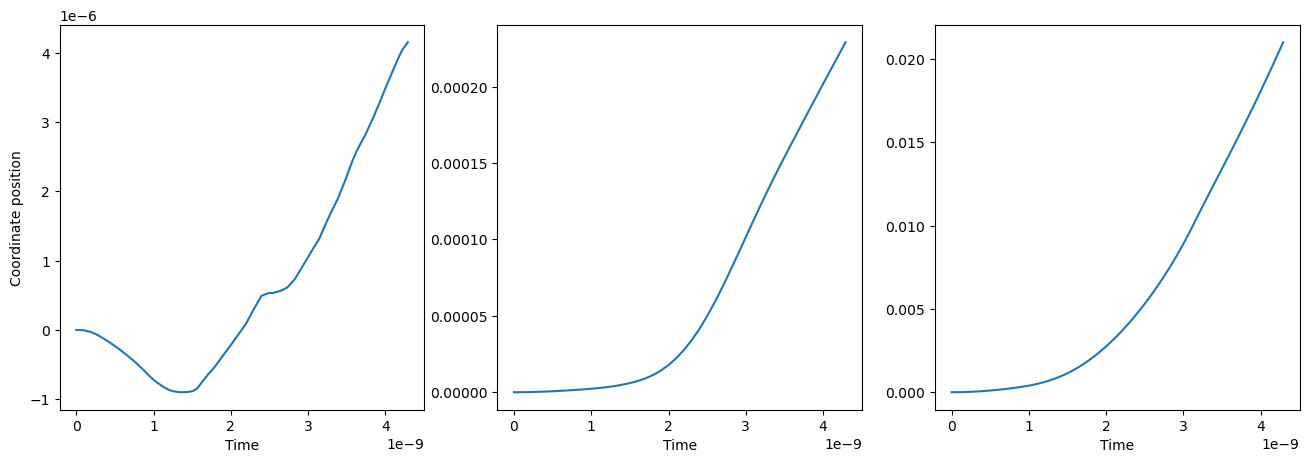

In [94]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for i in range(len(axes)):
    axes[i].plot(sol.t, sol.y[i])
    axes[i].set_xlabel('Time')
axes[0].set_ylabel('Coordinate position')

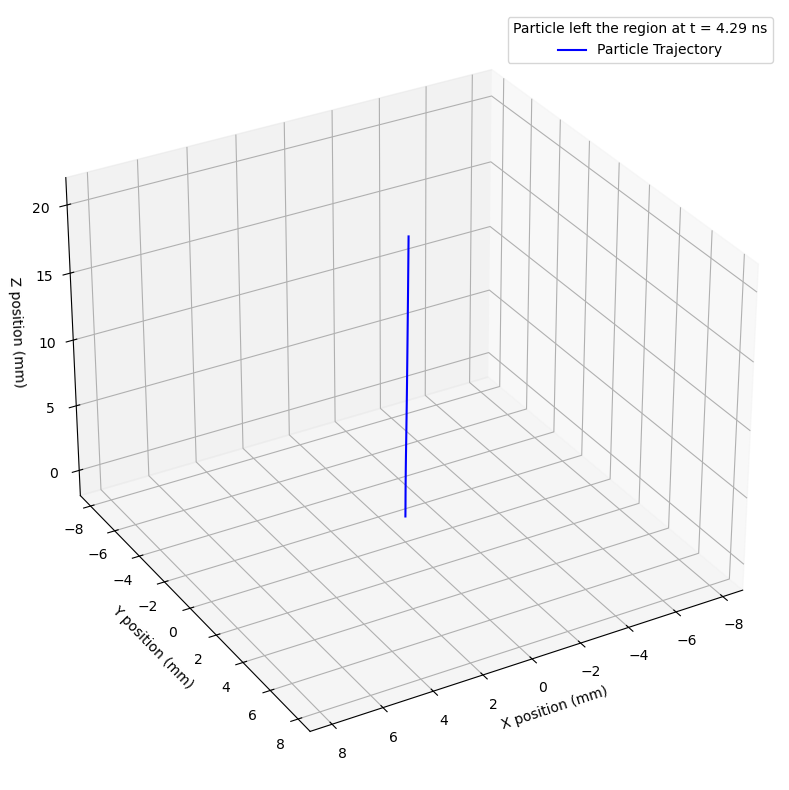

In [96]:
# Assuming 'sol' is the solution from solve_ivp as provided
# t = sol.t
# y = sol.y

# Extract position components from the solution
x = y[0]       # x positions
y_pos = y[1]   # y positions
z = y[2]       # z positions

# Convert positions from meters to millimeters for plotting
x_mm = x * 1e3
y_mm = y_pos * 1e3
z_mm = z * 1e3

# Create a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the trajectory
ax.plot(x_mm, y_mm, z_mm, label='Particle Trajectory', color='b')

# Set the axes labels
ax.set_xlabel('X position (mm)')
ax.set_ylabel('Y position (mm)')
ax.set_zlabel('Z position (mm)')

# Set the axes limits according to the specified space
ax.set_xlim(-8.5, 8.5)
ax.set_ylim(-8.5, 8.5)
ax.set_zlim(-1.5, 21.5)

# Add a grid
ax.grid(True)

# Extract the time when the particle leaves the region, if the event occurred
if sol.t_events[0].size > 0:
    exit_time = sol.t_events[0][0]
    exit_time_ns = exit_time * 1e9  # Convert time to nanoseconds for readability
    legend_text = f'Particle left the region at t = {exit_time_ns:.2f} ns'
else:
    legend_text = 'Particle did not leave the region during simulation'

# Add the legend with the exit time
ax.legend(title=legend_text, loc='upper right')

# Optionally, set the viewing angle for better visualization
ax.view_init(elev=30, azim=60)

# Show the plot
plt.tight_layout()
plt.show()

In [106]:
def sample_initial_conditions(N, sigma_pos, sigma_velo):
    """
    Generates initial conditions for N particles with positions and velocities sampled from normal distributions.

    Parameters:
        N (int): Number of particles.
        sigma_pos (float or array-like): Standard deviation(s) for initial positions.
            - If float, the same standard deviation is used for all axes.
            - If array-like (tuple, list, or NumPy array) of length 3, specifies (sigma_x, sigma_y, sigma_z).
        sigma_velo (float or array-like): Standard deviation(s) for initial velocities.
            - Same format as sigma_pos.

    Returns:
        numpy.ndarray: An array of shape (N, 6) where:
            - particles[:, :3] are positions (x, y, z).
            - particles[:, 3:] are velocities (vx, vy, vz).

    Raises:
        ValueError: If sigma_pos or sigma_velo are not a float or array-like of length 3.
    """
    import numpy as np

    # Handle sigma_pos
    if isinstance(sigma_pos, (tuple, list, np.ndarray)):
        if len(sigma_pos) != 3:
            raise ValueError("sigma_pos must be a float or an array-like of length 3.")
        sigma_x, sigma_y, sigma_z = sigma_pos
    elif isinstance(sigma_pos, (int, float)):
        sigma_x = sigma_y = sigma_z = sigma_pos
    else:
        raise ValueError("sigma_pos must be a float or an array-like of length 3.")

    # Handle sigma_velo
    if isinstance(sigma_velo, (tuple, list, np.ndarray)):
        if len(sigma_velo) != 3:
            raise ValueError("sigma_velo must be a float or an array-like of length 3.")
        sigma_vx, sigma_vy, sigma_vz = sigma_velo
    elif isinstance(sigma_velo, (int, float)):
        sigma_vx = sigma_vy = sigma_vz = sigma_velo
    else:
        raise ValueError("sigma_velo must be a float or an array-like of length 3.")

    # Initialize the particles array
    particles = np.zeros((N, 6))

    # Sample positions from normal distributions
    particles[:, 0] = np.random.normal(0, sigma_x, N)  # x positions
    particles[:, 1] = np.random.normal(0, sigma_y, N)  # y positions
    particles[:, 2] = np.random.normal(0, sigma_z, N)  # z positions

    # Sample velocities from normal distributions
    particles[:, 3] = np.random.normal(0, sigma_vx, N)  # x velocities
    particles[:, 4] = np.random.normal(0, sigma_vy, N)  # y velocities
    particles[:, 5] = np.random.normal(0, sigma_vz, N)  # z velocities

    return particles

In [108]:
sample_initial_conditions(100, 1e-5, 1e+5)

array([[-1.19816947e-06,  6.62859659e-06, -3.57696914e-06,
         9.79610887e+04, -6.61071044e+04,  1.08510525e+05],
       [ 2.54981378e-06,  2.00114802e-05, -8.27076580e-06,
        -4.55668856e+04, -5.62573878e+03,  1.50043072e+05],
       [ 8.23603217e-07,  6.56611806e-06,  2.47326156e-06,
        -2.04155784e+04, -5.28035293e+03,  7.48232514e+04],
       [-8.62900547e-06,  2.95644373e-06,  1.64382201e-07,
        -1.56355670e+05, -2.14114986e+05, -1.15983240e+05],
       [ 1.30349692e-05,  7.42043273e-06,  5.68809458e-06,
        -1.06977286e+05,  9.93329447e+03,  9.79147011e+04],
       [ 1.24025263e-05, -1.20855094e-06, -3.45984064e-06,
        -3.22090218e+04,  6.37748809e+04, -1.17613825e+05],
       [-3.27607255e-06, -9.82811479e-06, -1.08541444e-05,
         3.96155964e+04, -1.29474607e+05, -2.16585184e+05],
       [-3.81001363e-06, -9.36857772e-06,  3.40834523e-07,
         3.47037705e+04,  1.21828942e+05,  7.26899613e+04],
       [-4.73973366e-06, -4.83216020e-06,  6.295

Time comsumed for calculating these trajectories: 6.8214 seconds


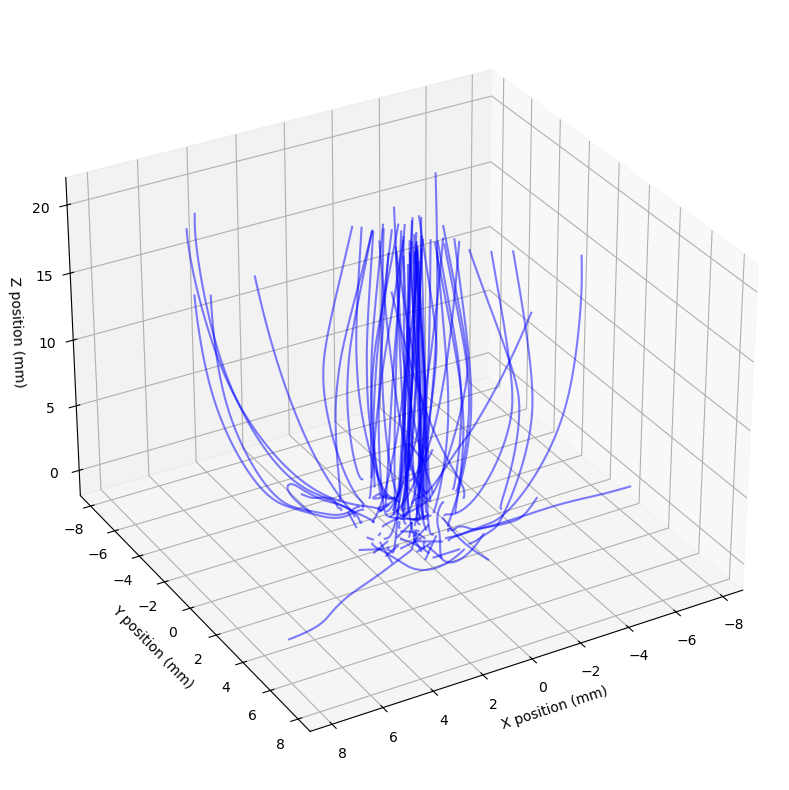

In [144]:
# Generate initial conditions for 100 particles
N = 100
sigma_pos = 1e-3    # Standard deviation of 1 mm for positions
sigma_velo = 1e+5   # Standard deviation of 0.01 m/s for velocities

# Sample initial positions and velocities
particles = sample_initial_conditions(N, sigma_pos, sigma_velo)

# Create a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Set the axes labels
ax.set_xlabel('X position (mm)')
ax.set_ylabel('Y position (mm)')
ax.set_zlabel('Z position (mm)')

# Set the axes limits according to the specified space
ax.set_xlim(-8.5, 8.5)
ax.set_ylim(-8.5, 8.5)
ax.set_zlim(-1.5, 21.5)

# Add a grid
ax.grid(True)

start_time = time.time()
# Simulate and plot trajectories for each particle
for i in range(N):
    # Initial conditions for the i-th particle
    y0 = particles[i]
    
    # Solve the trajectory using solve_ivp
    sol = solve_ivp(
        solve_traj,
        t_span=(t0, tf),
        y0=y0,
        args=(dc_interps, rf_interp, dc_conf, rf_range),
        max_step=5e-11,
        events=hit_boundary,
        method='RK45',
        dense_output=True
    )
    
    # Extract position components from the solution
    x = sol.y[0] * 1e3       # Convert to millimeters
    y_pos = sol.y[1] * 1e3
    z = sol.y[2] * 1e3
    
    # Plot the trajectory
    ax.plot(x, y_pos, z, color='b', alpha=0.5)

end_time = time.time()
print(f'Time comsumed for calculating these trajectories: {end_time - start_time:.4f} seconds')

# Optionally, adjust the viewing angle
ax.view_init(elev=30, azim=60)

# Show the plot
plt.tight_layout()
plt.show()

In [120]:
def hit_mcp(t, y, dc, rf, zones, rf_range):
    """
    Event function to detect when a particle crosses the MCP plane at z = 20 mm,
    within x and y ranges of [-5 mm, 5 mm].

    Parameters:
        t (float): Current time (required by solve_ivp but not used here).
        y (array-like): Current state vector [x, y, z, vx, vy, vz].
        dc, rf, rf_range: Additional arguments passed via `args` (not used in this function).
        zones (dict): Zones configuration dictionary (not used here).

    Returns:
        float: Difference between the particle's z-position and the MCP plane z-position.

    Note:
        - This function returns a positive value when the particle is below the MCP plane,
          zero when it is exactly at z = 20 mm, and negative when it is above the MCP plane.
        - The event is only considered valid when the particle's x and y positions are within
          the specified ranges of [-5 mm, 5 mm]. Otherwise, the function returns a positive
          value to prevent triggering the event.
    """
    import numpy as np

    # Extract position components
    x_pos, y_pos, z_pos = y[0], y[1], y[2]

    # Convert positions to millimeters for comparison
    x_mm = x_pos * 1e3
    y_mm = y_pos * 1e3
    z_mm = z_pos * 1e3

    # Define MCP plane z-position in millimeters
    z_mcp = 20.0  # z = 20 mm

    # Check if x and y are within the MCP area
    if -5.0 <= x_mm <= 5.0 and -5.0 <= y_mm <= 5.0:
        # Particle is within the MCP area; return the difference in z
        return z_mm - z_mcp
    else:
        # Particle is outside the MCP area; return a positive value to prevent event triggering
        # The positive value ensures the event function does not cross zero
        return 1.0  # Arbitrary positive value

# Set event attributes
hit_mcp.terminal = False  # Do not terminate the integration when this event occurs
hit_mcp.direction = 1     # Detect only when z increases through z_mcp (from below to above)

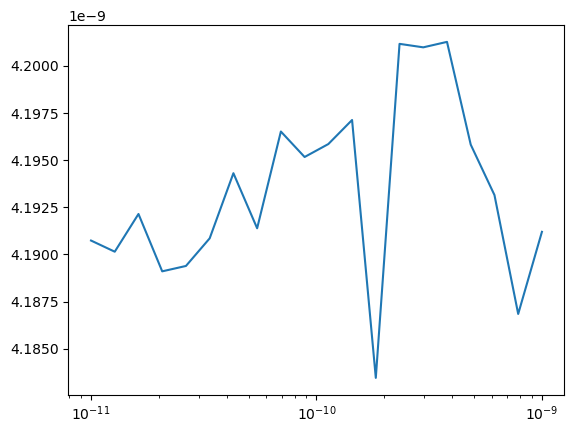

In [138]:
t0 = 0.0
tf = 6e-9
y0 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
steps = np.logspace(-11, -9, 20)
t_mcp = np.zeros(len(steps))

for i in range(len(steps)):
    sol = solve_ivp(
        solve_traj,
        t_span=(t0, tf),
        y0=y0,
        args=(dc_interps, rf_interp, dc_conf, rf_range),
        max_step=steps[i],
        events=(hit_boundary, hit_mcp),
        method='RK45',
        dense_output=True
    )
    t_mcp[i] = sol.t_events[1][0]

plt.plot(steps, t_mcp)
plt.xscale('log')

In [134]:
sol.t_events[1][0]

4.192253660817953e-09

In [164]:
start_time = time.time()
sample_initial_conditions(10000, sigma_pos, sigma_velo)
end_time = time.time()
print(end_time-start_time)

0.0009992122650146484
